In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

fatal: destination path 'master' already exists and is not an empty directory.


In [2]:
!ls master

IMG             signnames.csv   train.p
driving_log.csv test.p          valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import random

In [4]:
np.random.seed(0)

In [5]:
with open('master/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('master/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('master/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

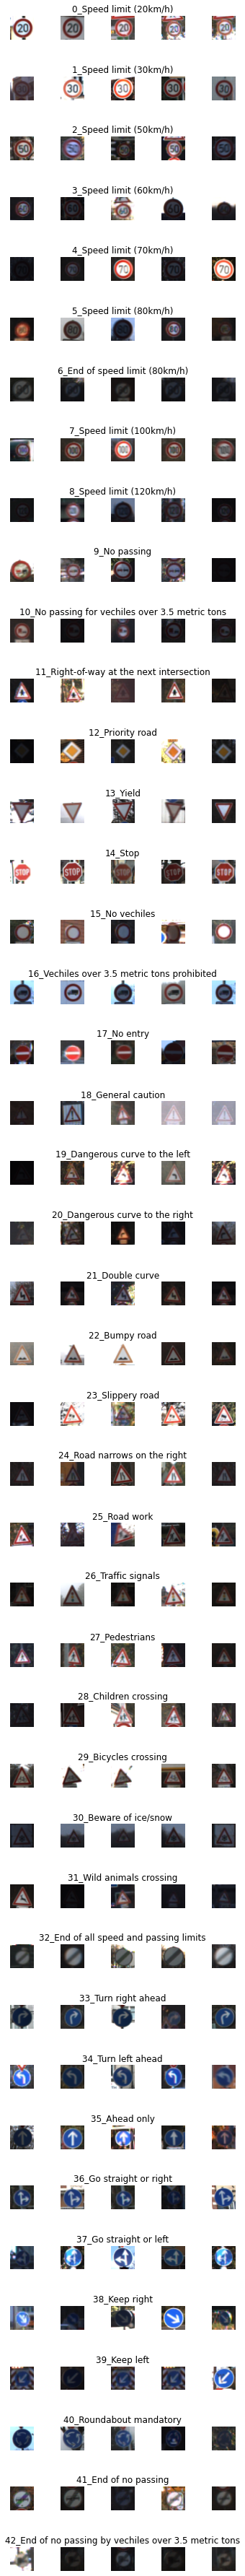

In [11]:
data = pd.read_csv('master/signnames.csv')
#data = pd.read_csv('signalisation-routiere.csv')
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row['SignName'])
            num_of_samples.append(len(x_selected))
    #(index, Series) Iteration

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

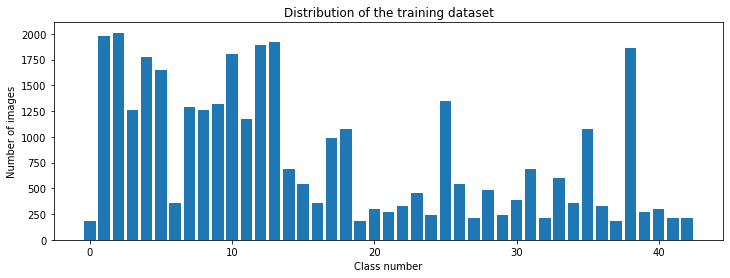

In [12]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


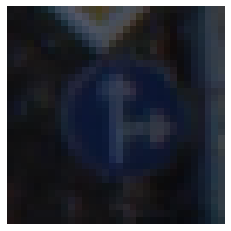

In [13]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


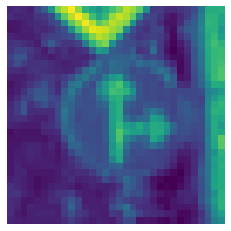

In [14]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


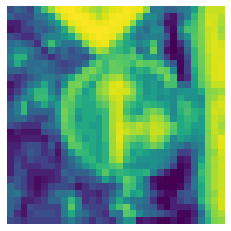

In [15]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [16]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


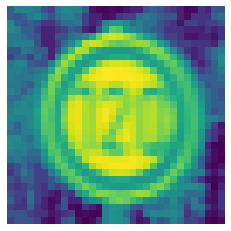

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [18]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


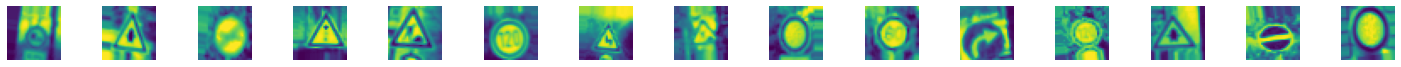

In [19]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [21]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)


In [22]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #Compile Model
  model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [23]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=600, epochs=10, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
600/600 [==============================] - 42s 70ms/step - loss: 0.6037 - accuracy: 0.8119 - val_loss: 0.1203 - val_accuracy: 0.9705
Epoch 2/10
600/600 [==============================] - 42s 71ms/step - loss: 0.4685 - accuracy: 0.8523 - val_loss: 0.1249 - val_accuracy: 0.9662
Epoch 3/10
600/600 [==============================] - 43s 72ms/step - loss: 0.4030 - accuracy: 0.8735 - val_loss: 0.0865 - val_accuracy: 0.9748
Epoch 4/10
600/600 [==============================] - 43s 72ms/step - loss: 0.3592 - accuracy: 0.8868 - val_loss: 0.0774 - val_accuracy: 0.9769
Epoch 5/10
600/600 [==============================] - 43s 72ms/step - loss: 0.3152 - accuracy: 0.9012 - val_loss: 0.0637 - val_accuracy: 0.9782
Epoch 6/10
600/600 [==============================] - 43s 72ms/step - loss: 0.2903 - accuracy: 0.9094 - val_loss: 0.0667 - val_accuracy: 0.9791
Epoch 7/10
600/600 [==============================] - 44s 73ms/step - loss: 0.2667 - accuracy: 0.9173 - val_loss: 0.0842 - val_accuracy:

Text(0.5, 0, 'epoch')

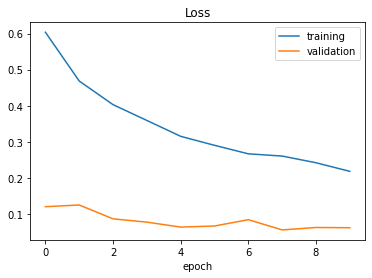

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

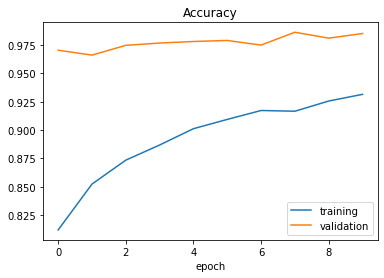

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.11597384512424469
Test accuracy: 0.965083122253418


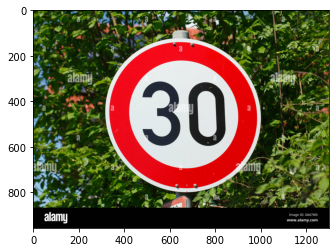

In [34]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
#r = '/Users/gcagada/Documents/data_bootcamp/w10/d10-day_5/road_work.jpg'
#img = Image.open(r)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


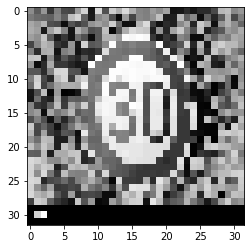

In [35]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [36]:
img = img.reshape(1, 32, 32, 1)

In [37]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis =-1 )))

predicted sign: [1]
